In [31]:
# Imports

import os
import math
import random
import operator
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import math, itertools
import statistics
import json
import hdbscan

from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import ShuffleSplit
from operator import itemgetter
from statistics import mean
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from collections import Counter
from matplotlib.ticker import StrMethodFormatter

from scipy.spatial import ConvexHull

In [89]:
# Helper Functions

def load_file(data_file_path):
    data_df = pd.read_csv(data_file_path, delimiter=";")
    return data_df
  
    
def plot_graph_new(results, max_calls, list_passed, title, name = "1"):
    x_pts = [i+1 for i in range(0, max_calls)]
    if list_passed:
        y_pts = results
    else:    
        y_pts = [results[i]['expected'] for i in range(0, max_calls)]
    print(y_pts)
    plt.title(title)
    plt.plot(x_pts, y_pts, linewidth=2)
    plt.xlabel("Call Number")
    plt.ylabel("Success Per Call Rate")
    plt.ylim(0, 0.4)
    plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.3f}'))
#     plt.axvline(x=0, color ="black", linewidth=1)
#     plt.axhline(y=0, color ="black", linewidth=1)
    plt.xticks(np.arange(1, max_calls+1, 1))
#     plt.show()
    plt.savefig(str(name) + ".pdf")
    plt.close()
    

# def plot_graph_both_axes(ratios, no_calls):
    

def div(a,b):
    if int(b) == 0:
        return 0.0
    else:
        return a/b
    

# Used for creating all possible combinations of the features.
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = iterable
    return itertools.chain.from_iterable(combinations(s, r) for r in range(len(s)+1))


def convert(list): 
    return tuple(list) 


def construct_dict(feature_comb):
    new_dict = {}
    new_dict['education'] = convert(feature_comb[0])
    new_dict['job'] = convert(feature_comb[2])
    new_dict['marital'] = convert(feature_comb[1])
    new_dict['default'] = convert(feature_comb[3])
    new_dict['loan'] = convert(feature_comb[4])
    new_dict['housing'] = convert(feature_comb[5])
    return new_dict


# This was the old metric (reward per call rate).
# def compute_expected_reward_feature_set_new(fs_df, no_calls_considered):
#     expected_values_calls = []
#     len_df = len(fs_df)
#     for i in range(1, no_calls_considered + 1):
#         expected_values_calls.append({'neg_value':0.0, 'pos_value':0.0, 'count':0, 'expected':0.0})
#         for index, row in fs_df.iterrows():
#             no_calls = row['campaign']
#             if no_calls <= i:
#                 if row['y'] == "yes":
#                     expected_values_calls[i-1]['pos_value'] += ((no_calls_considered+1) - no_calls)
#                 else:
#                     expected_values_calls[i-1]['neg_value'] += (-no_calls)
#             else:
#                 expected_values_calls[i-1]['neg_value'] += (-i)
#             expected_values_calls[i-1]['count'] += 1
#     for loc, item in enumerate(expected_values_calls):
#         expected_values_calls[loc]['expected'] = (expected_values_calls[loc]['pos_value'] + expected_values_calls[loc]['neg_value'])/len_df
#     return expected_values_calls


# This is the new metric (success per call rate).
def compute_expected_succ_per_call_rate_feature_set(fs_df, no_calls_considered):
    expected_values_call_nums = []
    for i in range(1, no_calls_considered + 1):
        expected_values_call_nums.append({'succ':0, 'total_calls':0, 'expected':0.0})
        for index, row in fs_df.iterrows():
            no_calls = row['campaign']
            if no_calls <= i:
                if row['y'] == "yes":
                    expected_values_call_nums[i-1]['succ'] += 1
                expected_values_call_nums[i-1]['total_calls'] += no_calls
            else:
                expected_values_call_nums[i-1]['total_calls'] += i
    for loc, item in enumerate(expected_values_call_nums):
        expected_values_call_nums[loc]['expected'] = div(item['succ'], item['total_calls'])
    return expected_values_call_nums


def compute_optimal_call_no(results):
    max_loc = max(range(len(results)), key=lambda index: results[index]['expected'])
    if max_loc == 0 and results[max_loc]['expected'] == 0.0:
        return -1
    return max_loc


# Given a dictionary of what attributes comprise a feature set, we can get all rows corresponding to this feature set.
def extract_rows_feature_set(fs_df, feature_labels = {'education':['tertiary', 'unknown'], 
                                                      'job':['management', 'technician', 'blue-collar'], 
                                                      'marital':['single'], 'default':['no'], 
                                                      'housing':['no'], 'loan':['no']}):
    for key in feature_labels:
        feature_labels_query_str = ''
        arr = feature_labels[key]
        for label in arr:
            feature_labels_query_str += (key + ' == "'+ label + '" | ')
        feature_labels_query_str = feature_labels_query_str[:-3]
        fs_df = fs_df.query(feature_labels_query_str)
    return fs_df


def find_matching_attribute_comb(row_value, all_combs):
    query = None
    for comb in all_combs:
        for item in comb:
            if item == row_value:
                query = comb
    return query


def compute_metric(df):
    total_calls = 0
    total_successes = 0
    for loc, row in df.iterrows():
        if row['y'] == "yes":
            total_successes += 1
        total_calls += row['campaign']
    return div(total_successes, total_calls)

def compute_metric_2(df):
    total_calls = 0
    total_successes = 0
    for loc, row in df.iterrows():
        if row['y'] == "yes":
            total_successes += 1
        total_calls += min(row['campaign'], )
    return div(total_successes, total_calls)


def compute_metric_for_each_attribute(all_values, df, attrib):
    metric_vals = np.zeros(shape=(len(all_values),1))
    for index, value in enumerate(all_values):
        v_query = "{0} == '{1}'".format(attrib, value)
        dataset_query = df.query(v_query)
        metric_val = compute_metric(dataset_query)
        metric_vals[index] = metric_val
#         print(v_query, metric_val, dataset_query.shape)
    return metric_vals


def compute_metric_for_each_attribute_range(all_values, df, attrib):
    metric_vals = np.zeros(shape=(len(all_values),1))
    query_strings = []
    for index, value in enumerate(all_values):
        v_query = "{0} >= {1} & {2} < {3}".format(attrib, value[0], attrib, value[1])
        dataset_query = df.query(v_query)
        metric_val = compute_metric(dataset_query)
        metric_vals[index] = metric_val
        query_strings.append(v_query)
#         print(v_query, metric_val, dataset_query.shape)
    return metric_vals, query_strings


def find_combinations(sub_attributes, ratios):
    num_iter = len(ratios)
    sil_scores = []
    # Making use of the K-Means algorithm ... number of centroids are from 2 to n-1.
    for clust_num in range(2, num_iter):
        kmeans = KMeans(n_clusters = clust_num)
        kmeans.fit(ratios.reshape(-1,1))
        results = kmeans.labels_
        sil_scores.append((silhouette_score(ratios.reshape(-1,1), results, metric='euclidean'), results, clust_num))
#     print(sil_scores)
    # We make use of the silhouette score to determine the ideal number of centroids.
    sorted_sil_scores = sorted(sil_scores, key=lambda x: x[0], reverse = True)
    # We then use this ideal number of centroids to determine which sub attributes should be aggregated.
    joined_sub_attributes = []
    for i in range(0, sorted_sil_scores[0][2]):
        joined_sub_attributes.append([])
    join_list = sorted_sil_scores[0][1]
    for index, value in enumerate(join_list):
        pos = join_list[index]
        joined_sub_attributes[pos].append(sub_attributes[index])
    return_joined_sub_attributes = []
    for arr in joined_sub_attributes:
        similar_els_gp = []
        for item in arr:
            similar_els_gp.append(str(item))
        return_joined_sub_attributes.append(similar_els_gp)
#     print(return_joined_sub_attributes)
    return return_joined_sub_attributes

# The following is the format of the way in which this method should be called.
# find_combinations(['a', 'b', 'c', 'd'], np.array([1, 4, 7, 90]), "job").

def find_all_cust_feature_set(fs, df):
    comb = {
        'education':fs[0], 
         'job':fs[1], 
         'marital':fs[2], 
         'default':fs[3], 
         'loan':fs[4], 
         'housing':fs[5]
    }
    res_1 = df.query(fs[6])
    res_2 = res_1.query(fs[7])
    res_final = extract_rows_feature_set(res_2, comb)
    return res_final


def construct_hull_points(results, max_calls):
    pts = []
    for x in range(0, max_calls):
        s = results[x]['succ']
        c = results[x]['total_calls']
        pts.append([c,s])
#     print("Num points is ", len(pts))
    pts = np.array(pts)
    try:
        hull = ConvexHull(pts)
        verts = hull.vertices
#         print(pts)
#         plt.plot(pts[:,0], pts[:,1], 'o')
#         for simplex in hull.simplices:
#             plt.plot(pts[simplex, 0], pts[simplex, 1], 'k-')
        if not np.isin(max_calls - 1, verts):
            verts = np.append(max_calls - 1, verts)
        verts = np.sort(verts)
        return verts.tolist()
    except:
        return False

    
def gradient_update(key, fs_pick):
    fs = fs_pick[key]
    fs_results = fs['results']
    hull_pts = fs['hull_points']
    loc = fs['loc']
    max_loc = fs['max_num_pts']
    grad = 0.0
    if loc <= max_loc:
        if loc == 0:
            grad = div(fs_results[hull_pts[loc]]['succ'], fs_results[hull_pts[loc]]['total_calls'])
        else:
            grad = div(fs_results[hull_pts[loc]]['succ'] - fs_results[hull_pts[loc-1]]['succ'] , fs_results[hull_pts[loc]]['total_calls'] - fs_results[hull_pts[loc-1]]['total_calls'])
        fs_pick[key]['grad'] = grad
    else:
        fs_pick[key]['finished'] = True

        
def get_features(row, feature_names):
    fs = []
    for index, val in enumerate(feature_names):
        if "campaign" not in val:
            if int(row[index]) == 1:
                fs.append(val)
    return fs


def succ_calls_each_attribute(all_values, df, attrib):
    metric_vals = np.zeros(shape=(len(all_values),1))
    query_strings = []
    results = []
    # Find the number of calls and successes for each attribute value.
    for index, value in enumerate(all_values):
        v_query = "{0} == '{1}'".format(attrib, value)
        dataset_query = df.query(v_query)
        num_succ = 0
        num_calls = 0
        for index, row in dataset_query.iterrows():
            if row['y'] == "yes":
                num_succ += 1
            num_calls += row['campaign']
        results.append([num_calls, num_succ, value])
    res = np.array(results)
    return res

In [76]:
%%time
# Code that sets up values to construct all possible feature combinations.

# Age query strings.
# age_query_strings = ['age < 26','age >= 26 & age <=60','age >60']
# age_query_strings = ['age >= 10 & age <= 32', 'age >= 33 & age <= 40', 'age >= 50 & age <= 59', 'age >= 60']
age_query_strings = ['age >= 10 & age <= 34', 'age >= 35 & age <= 45', 'age >= 46']

# Balance query strings.
balance_query_strings = ['balance <= 450',' balance > 450']

# Max call number to consider.
max_calls = 20

# Pull and filter all calls <= 20.
current_dir = os.getcwd()
mkt_df = load_file(current_dir + '/bank-full.csv')
mkt_df_filtered = mkt_df[(mkt_df['campaign']>=1) & (mkt_df['campaign']<=max_calls)]
mkt_df_filtered = mkt_df_filtered[['job', 'marital', 'education', 'default', 'housing', 'loan', 'age', 'balance', 'campaign', 'y']]
mkt_df_filtered_kmeans = mkt_df_filtered[['job', 'marital', 'education', 'default', 'housing', 'loan', 'age', 'balance']]
print(mkt_df.shape)

(45211, 17)
CPU times: user 43.7 ms, sys: 8.17 ms, total: 51.8 ms
Wall time: 50 ms


In [139]:
%%time

# Main code ... orchestrates everything!

# Splitting dataframe into data and result dataframes.
X = mkt_df_filtered.iloc[:,0:len(mkt_df_filtered.columns)-1]
y = mkt_df_filtered.iloc[:,-1]

# cut_points = [10, 20]

cut_points = [20]

for cp in cut_points:

    for j in range(1,2):
        
        phase_batch = {}
        kf = KFold(n_splits=5, shuffle=True)
        i = 0
        for train_index, test_index in kf.split(X):
            i += 1
            
            print("I is:", i)

            train_df = mkt_df_filtered.iloc[train_index]
            test_df = mkt_df_filtered.iloc[test_index]

            # At this point, we can run computations for the success rate of each sub attribute and join
            # the sub-attributes based on the output of k-means.
            poss = []

            # Education.
#             all_ed = ['tertiary', 'secondary', 'primary', 'unknown']
#             metric_vals = succ_calls_each_attribute(all_ed, train_df, 'education')
#             print(metric_vals)
#             education_cmbs = find_combinations(all_ed, metric_vals)

            all_jobs = ['student', 'retired', 'unemployed', 'admin.', 'management', 'self-employed', 'technician', 'unknown', 'services', 'housemaid', 'blue-collar', 'entrepreneur']
            metric_vals = succ_calls_each_attribute(all_jobs, mkt_df_filtered, 'job')
            print(metric_vals)
        
#             # Occupation.
#             all_jobs = ['student', 'retired', 'unemployed', 'admin.', 'management', 'self-employed', 'technician', 'unknown', 'services', 'housemaid', 'blue-collar', 'entrepreneur']
#             metric_vals = compute_metric_for_each_attribute(all_jobs, train_df, 'job')
#             print(metric_vals)
#             job_cmbs = find_combinations(all_jobs, metric_vals)

#             # Marital.
#             all_ms = ['married', 'single', 'divorced']
#             metric_vals = succ_calls_each_attribute(all_ms, train_df, 'marital')
#             metric_vals = compute_metric_for_each_attribute(all_ms, train_df, 'marital')
#             print(metric_vals)
#             marital_cmbs = find_combinations(all_ms, metric_vals)
            
            break

I is: 1
[['2084' '269' 'student']
 ['5225' '516' 'retired']
 ['3046' '202' 'unemployed']
 ['12605' '631' 'admin.']
 ['25611' '1301' 'management']
 ['4240' '187' 'self-employed']
 ['20764' '839' 'technician']
 ['897' '34' 'unknown']
 ['10634' '369' 'services']
 ['3383' '108' 'housemaid']
 ['25754' '708' 'blue-collar']
 ['4009' '121' 'entrepreneur']]
CPU times: user 3.14 s, sys: 0 ns, total: 3.14 s
Wall time: 3.13 s


In [140]:
metric_vals

array([['2084', '269', 'student'],
       ['5225', '516', 'retired'],
       ['3046', '202', 'unemployed'],
       ['12605', '631', 'admin.'],
       ['25611', '1301', 'management'],
       ['4240', '187', 'self-employed'],
       ['20764', '839', 'technician'],
       ['897', '34', 'unknown'],
       ['10634', '369', 'services'],
       ['3383', '108', 'housemaid'],
       ['25754', '708', 'blue-collar'],
       ['4009', '121', 'entrepreneur']], dtype='<U21')

In [78]:
import matplotlib.pyplot as plt

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

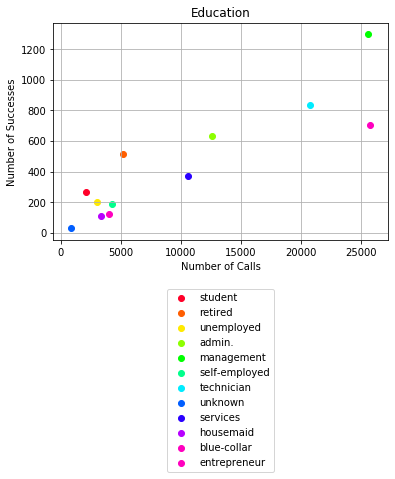

In [141]:
NUM_COLORS = 20
cm = plt.get_cmap('gist_rainbow')

i = 0
fig = plt.figure(1)
ax = fig.add_subplot(111)
for el in metric_vals:
    ax.scatter(int(el[0]), int(el[1]), label = el[2], c = cm(1.*i/NUM_COLORS))
    i += 2
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,-0.2))
ax.set_title("Education")
ax.set_xlabel("Number of Calls")
ax.set_ylabel("Number of Successes")
ax.grid('on')
fig.savefig('samplefigure.pdf', bbox_extra_artists=(lgd,text), bbox_inches='tight')

In [132]:
my_set = set(['student', 'retired', 'unemployed', 'admin.', 'management', 'self-employed', 'technician', 'unknown', 'services', 'housemaid', 'blue-collar', 'entrepreneur'])

In [133]:
to_minus = set(['management', 'technician', 'blue-collar'])

In [136]:
to_minus_2 = set(['admin.', 'services', 'retired'])

In [134]:
red = my_set - to_minus

In [137]:
red = red - to_minus_2

In [138]:
red

{'entrepreneur',
 'housemaid',
 'self-employed',
 'student',
 'unemployed',
 'unknown'}